In [1]:
import pandas as pd
import numpy as np

prefix = './logs/single-worker_500tps_'
#prefix = '../'
df = pd.concat([pd.read_csv(prefix+'logs-server.csv', sep=';'), pd.read_csv(prefix+'logs-worker.csv', sep=';')])

In [2]:
df.sample(5)

,accuracy,fMeasure,loss,numTuplesSeen,partition,timestamp,vectorClock
172,0.341193,0.345402,0.256128,1494.0,0,1584288397947,172
76,0.327455,0.319324,0.365704,902.0,0,1584288273002,76
677,0.371335,0.356900,-1.000000,NaN,-1,1584289039898,677
659,0.348780,0.342172,0.774605,4461.0,0,1584289017252,659
239,0.332787,0.333386,-1.000000,NaN,-1,1584288474851,239


In [3]:
numPartitions = 1

In [4]:
df.loc[df['partition'] == -1, 'partition'] = numPartitions
numPartitions = numPartitions + 1

In [5]:
maxVC = [0 for i in range(numPartitions)]
maxNumTuples = [0 for i in range(numPartitions)]
for p in range(numPartitions):
    maxVCWithinPartition = max(df[df['partition'] == p]['vectorClock'])
    maxVC[p] = max(maxVC[p], maxVCWithinPartition)
    
    maxNumTuplesWithinPartition = max(df[df['partition'] == p]['numTuplesSeen'])
    maxNumTuples[p] = max(maxNumTuples[p], maxNumTuplesWithinPartition)
maxVC = min(maxVC)
maxVC = 750
print('maxVC: ' + str(maxVC))

print('maxNumTuples: ' + str(maxNumTuples))

maxVC: 750
maxNumTuples: [5449.0, 0]


In [6]:
df = df[df['vectorClock'] <= maxVC].reset_index().sort_values('vectorClock')

In [7]:
data = {
    **{'loss'+str(i): [] for i in range(numPartitions)},
    **{'fMesaure'+str(i): [] for i in range(numPartitions)},
    **{'accuracy'+str(i): [] for i in range(numPartitions)},
    **{'numTuplesSeen'+str(i): [] for i in range(numPartitions)}
}

sumNumTuplesSeen = [0 for i in range(maxVC+1)]
for p in range(numPartitions):
    for index, row in df[df['partition'] == p].iterrows():
        data['loss'+str(p)] += [row['loss']]
        data['fMesaure'+str(p)] += [row['fMeasure']]
        data['accuracy'+str(p)] += [row['accuracy']]
        
        vc = int(row['vectorClock'])
    
        if p < numPartitions - 1: #worker
            sumNumTuplesSeen[vc] += row['numTuplesSeen']
            data['numTuplesSeen'+str(p)] += [row['numTuplesSeen']]
        else: #server
            avgNumTuplesPerPartition = int(sumNumTuplesSeen[vc] / (numPartitions-1))
            data['numTuplesSeen'+str(p)] += [avgNumTuplesPerPartition]

In [8]:
data = pd.DataFrame(data)

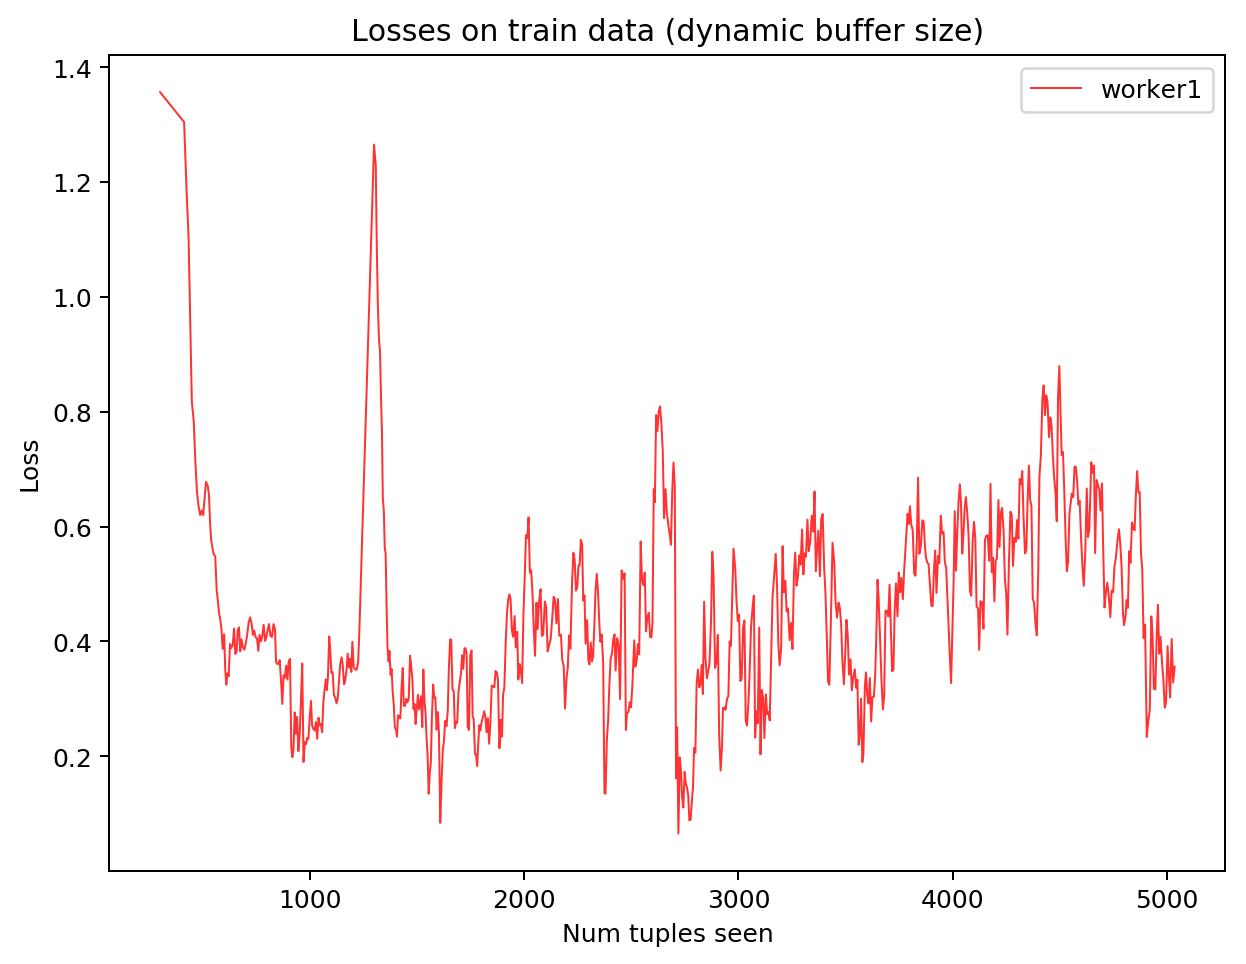

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, ylim

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

data['x'] = [i for i in range(len(data))]

# create a color palette
palette = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(numPartitions - 1):
    colY = 'loss' + str(i)
    colX = 'numTuplesSeen' + str(i)
    
    isServerPartition = i == numPartitions - 1
    alpha = 0.8
    label = 'server' if isServerPartition else 'worker'+str(i+1)
    linewidth = 0.8
    plt.plot(data[colX], data[colY], marker='', color=palette[i], linewidth=linewidth, alpha=alpha, label=label)

#ylim(0, 1e-4)
plt.title('Losses on train data (dynamic buffer size)')
plt.ylabel('Loss')
plt.xlabel('Num tuples seen')
plt.legend(loc=1, ncol=2)
plt.show()

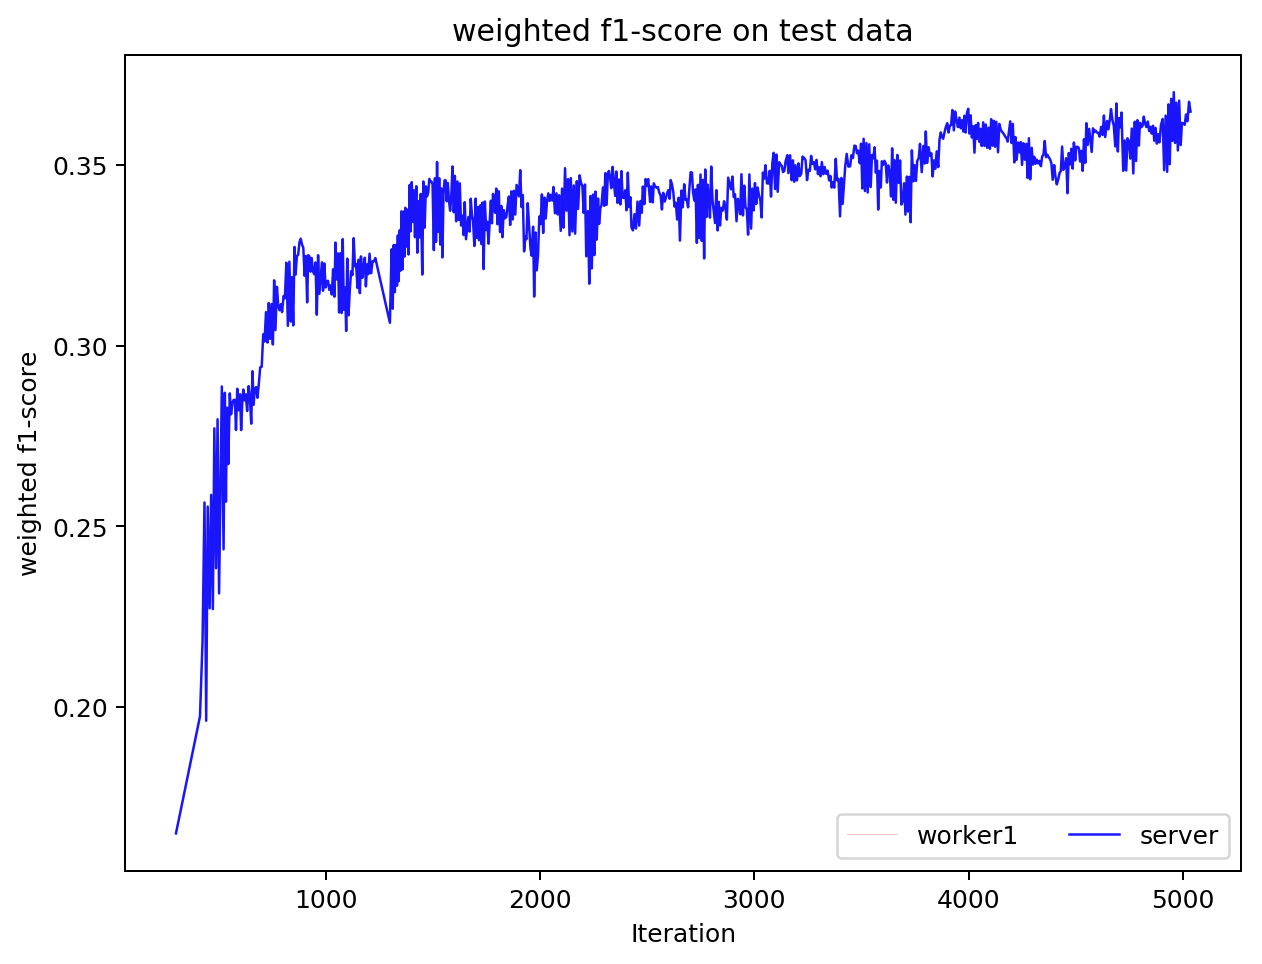

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, ylim

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

data['x'] = [i for i in range(len(data))]

# create a color palette
palette = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(numPartitions):
    colY = 'fMesaure' + str(i)
    colX = 'numTuplesSeen' + str(i)
    
    isServerPartition = i == numPartitions - 1
    alpha = 0.9 if isServerPartition else 0.2
    label = 'server' if isServerPartition else 'worker'+str(i+1)
    linewidth = 1 if isServerPartition else 0.5
    plt.plot(data[colX], data[colY], marker='', color=palette[i], linewidth=linewidth, alpha=alpha, label=label)

#ylim(0, 1e-4)
plt.title('weighted f1-score on test data')
plt.ylabel('weighted f1-score')
plt.xlabel('Iteration')
plt.legend(loc=4, ncol=2)
plt.show()

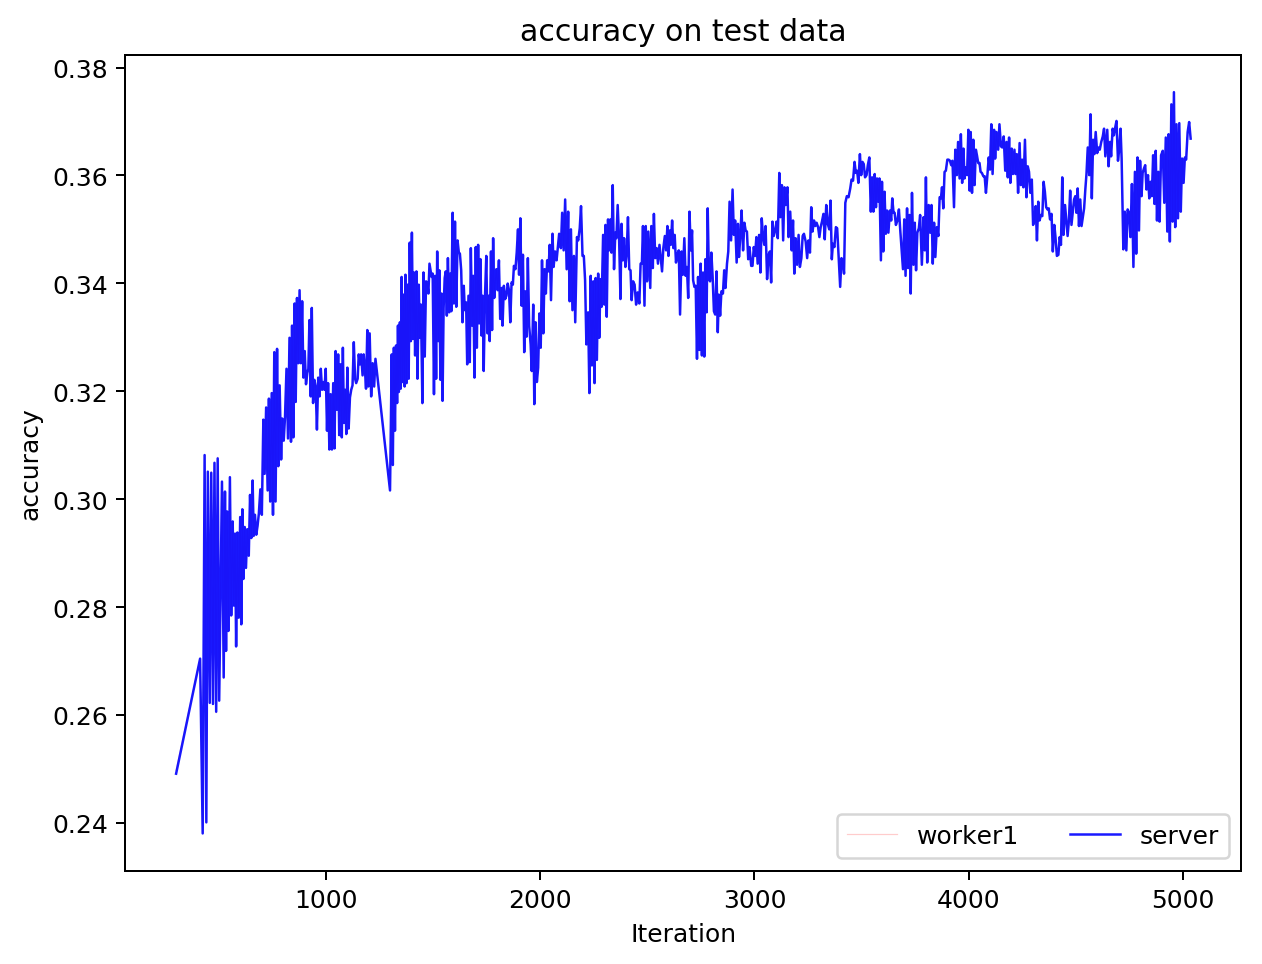

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, ylim

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

data['x'] = [i for i in range(len(data))]

# create a color palette
palette = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(numPartitions):
    colY = 'accuracy' + str(i)
    colX = 'numTuplesSeen' + str(i)
    
    isServerPartition = i == numPartitions - 1
    alpha = 0.9 if isServerPartition else 0.2
    label = 'server' if isServerPartition else 'worker'+str(i+1)
    linewidth = 1 if isServerPartition else 0.5
    plt.plot(data[colX], data[colY], marker='', color=palette[i], linewidth=linewidth, alpha=alpha, label=label)

#ylim(0, 1e-4)
plt.title('accuracy on test data')
plt.ylabel('accuracy')
plt.xlabel('Iteration')
plt.legend(loc=4, ncol=2)
plt.show()